In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import zipfile
import os
from pycocotools.coco import COCO
from collections import Counter

In [43]:
# val_dataset_path = '/content/drive/MyDrive/U of Manchester/Robotics Assignment/data/val2017.zip'
# train_dataset_path = '/content/drive/MyDrive/U of Manchester/Robotics Assignment/data/train2017.zip'
# annotations_dataset_path = '/content/drive/MyDrive/U of Manchester/Robotics Assignment/data/annotations_trainval2017.zip'
# extract_path = '//content/drive/MyDrive/U of Manchester/Robotics Assignment/data/coco'

# os.makedirs(extract_path, exist_ok=True)

# with zipfile.ZipFile(val_dataset_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# with zipfile.ZipFile(train_dataset_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# with zipfile.ZipFile(annotations_dataset_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [44]:
#load annotation files
annotation_path_val = '/content/drive/MyDrive/U of Manchester/Robotics Assignment/data/coco/annotations/instances_val2017.json'
annotation_path_train = '/content/drive/MyDrive/U of Manchester/Robotics Assignment/data/coco/annotations/instances_train2017.json'

coco_val = COCO(annotation_path_val)
coco_train = COCO(annotation_path_train)

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
loading annotations into memory...
Done (t=23.67s)
creating index...
index created!


In [45]:
# from collections import Counter

# def build_image_label_map(coco, max_images=None):
#     image_label_map = {}
#     img_ids = coco.getImgIds()
#     if max_images:
#         img_ids = img_ids[:max_images]
#     for img_id in img_ids:
#         anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
#         if anns:
#             #only pick the most common object in the image
#             cat_ids = [ann['category_id'] for ann in anns]
#             most_common_cat = Counter(cat_ids).most_common(1)[0][0]
#             fname = coco.loadImgs(img_id)[0]['file_name']
#             image_label_map[fname] = most_common_cat
#     return image_label_map


In [46]:
from collections import Counter, defaultdict

def build_image_label_map(coco, top_k=20, target_count=8000):
    img_ids = coco.getImgIds()
    temp_labels = {}
    cat_count = Counter()

    # most common object per image - no filtering yet
    for img_id in img_ids:
        anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
        if not anns:
            continue
        cat_ids = [ann['category_id'] for ann in anns]
        most_common_cat = Counter(cat_ids).most_common(1)[0][0]
        fname = coco.loadImgs(img_id)[0]['file_name']
        temp_labels[fname] = most_common_cat
        cat_count[most_common_cat] += 1

    #get only the top k categories
    top_cats = set([cat for cat, _ in cat_count.most_common(top_k)])
    label_to_index = {cat_id: idx for idx, cat_id in enumerate(sorted(top_cats))}

    # get images from top_k categories only until target_count is reached
    image_label_map = {}
    class_image_counts = defaultdict(int)

    for fname, cat_id in temp_labels.items():
        if cat_id in top_cats:
            image_label_map[fname] = label_to_index[cat_id]
            class_image_counts[cat_id] += 1
            if len(image_label_map) >= target_count:
                break

    return image_label_map, label_to_index


In [47]:
def paths_and_labels(image_label_map, img_dir):
    paths = []
    labels = []
    for fname, label in image_label_map.items():
        path = os.path.join(img_dir, fname)
        if os.path.exists(path):
            paths.append(path)
            labels.append(label)
    return paths, labels


In [48]:
# Cell 7: generate maps and inverse mappings
train_image_label_map, train_label_to_index = build_image_label_map(coco_train, target_count=8000)
val_image_label_map,   val_label_to_index   = build_image_label_map(coco_val, target_count=2000)

# Invert for display (index -> original COCO category ID)
train_index_to_label = {v: k for k, v in train_label_to_index.items()}
val_index_to_label   = {v: k for k, v in val_label_to_index.items()}

# Cell 8: check sizes
print(f"Train images: {len(train_image_label_map)}")
print(f"Val images:   {len(val_image_label_map)}")

# Cell 9: get file paths and 0-based labels
train_image_paths, train_labels = paths_and_labels(
    train_image_label_map,
    '/content/drive/MyDrive/U of Manchester/Robotics Assignment/data/coco/train2017'
)
val_image_paths,   val_labels   = paths_and_labels(
    val_image_label_map,
    '/content/drive/MyDrive/U of Manchester/Robotics Assignment/data/coco/val2017'
)

Train images: 8000
Val images:   2000


In [49]:
print("Number of classes:", len(set(train_labels)))

Number of classes: 20


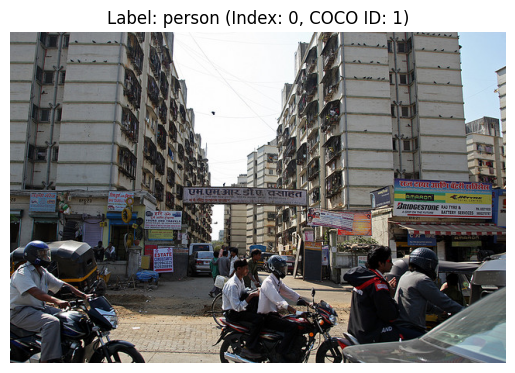

Label index: 0


In [41]:
import matplotlib.pyplot as plt
from PIL import Image

# Pick a validation sample
tag_idx    = 7
img_path   = val_image_paths[tag_idx]
label_idx  = val_labels[tag_idx]

# Map back to original COCO ID and name
original_category_id = val_index_to_label[label_idx]
category_name       = coco_val.loadCats(original_category_id)[0]['name']

# Display
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Label: {category_name} (Index: {label_idx}, COCO ID: {original_category_id})")
plt.show()

print(f"Label index: {label_idx}")


In [27]:
train_image_label_map = build_image_label_map(coco_train, max_images=8000)  # keep it small for now
val_image_label_map = build_image_label_map(coco_val)  # full 5000

In [ ]:
train_image_paths, train_labels = paths_and_labels(train_image_label_map, '/content/drive/MyDrive/U of Manchester/Robotics Assignment/data/coco/train2017')
val_image_paths, val_labels = paths_and_labels(val_image_label_map, '/content/drive/MyDrive/U of Manchester/Robotics Assignment/data/coco/val2017')

In [ ]:
print(len(train_image_paths))
print(len(val_image_paths))

In [29]:
import matplotlib.pyplot as plt
from PIL import Image

# Pick the first validation image and label
img_path = val_image_paths[1]
label_id = val_labels[1]

# Get category name from label ID
category_name = coco_val.loadCats(label_id)[0]['name']

# Load and display image
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Label: {category_name} (ID: {label_id})")
plt.show()
print(val_labels[0])


KeyError: 0